In [179]:
%pylab inline
from datetime import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import metrics

pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [201]:
station_name_length=7
time_zone_range=60 #minutes
fix_columns=['date','weekday','time','from','to','vehicle']
fit_columns=['date','weekday','time']
label_column=['occupancy']

label_map={"low":0,"medium":1,"high":2}

# 读取数据和格式转换

In [166]:
stations=pd.read_csv("stations.csv",sep=',',header=0)
del stations['alternative-fr']
del stations['alternative-nl']
del stations['alternative-de']
del stations['alternative-en']
del stations['country-code']
stations['URI']=stations.URI.map(lambda x:x[-station_name_length:])
stations.sort_values(by=['avg_stop_times'],ascending=False)

,URI,name,longitude,latitude,avg_stop_times
97,8814001,Brussel-Zuid/Bruxelles-Midi,4.336531,50.835707,686.615607
94,8812005,Brussel-Noord/Bruxelles-Nord,4.360846,50.859663,640.265896
89,8813003,Brussel-Centraal/Bruxelles-Central,4.356801,50.845658,634.164740
16,8821006,Antwerpen-Centraal,4.421101,51.217200,467.982659
15,8821121,Antwerpen-Berchem,4.432221,51.199230,421.644509
312,8833001,Leuven,4.715866,50.882280,351.916185
202,8892007,Gent-Sint-Pieters,3.710675,51.035896,309.014451
354,8822004,Mechelen,4.482785,51.017648,306.523121
318,8841004,Liège-Guillemins,5.566695,50.624550,269.124277
410,8811601,Ottignies,4.569360,50.673667,253.471098


In [167]:
train_dataset=pd.read_csv("trains_train.csv",sep=',',header=0)

train_dataset['from']=train_dataset['from'].map(lambda x:x[-station_name_length:])
train_dataset['to']=train_dataset['to'].map(lambda x:x[-station_name_length:])
train_dataset['weekday']=train_dataset['date'].map(lambda x:datetime.strptime(x,"%Y-%M-%d").weekday()+1)
def time2zone(value):
    extra=0
    if value.endswith("PM"):
        extra=12*60/time_zone_range
    values=value[:8].split(":")
    zone=60*int(values[0])+int(values[1])
    return zone/time_zone_range+1+extra

train_dataset['time']=train_dataset['time'].map(time2zone)
train_dataset['time']=train_dataset['time'].astype(int)
del train_dataset['connection']

train_dataset=train_dataset[fix_columns+label_column]
train_dataset=train_dataset[(train_dataset['to']!="(null)") & (train_dataset['from']!="(null)")]
train_dataset

,date,weekday,time,from,to,vehicle,occupancy
0,2016-07-27,3,21,8813003,0000000,IC1518,high
1,2016-07-27,3,21,8813003,0000000,IC1518,high
2,2016-07-27,3,21,8813003,0000000,IC1518,high
3,2016-07-27,3,21,8813003,0000000,IC1518,high
4,2016-07-27,3,21,8813003,0000000,IC1518,high
5,2016-07-27,3,21,8813003,0000000,IC1518,high
6,2016-07-27,3,21,8813003,0000000,IC1518,high
7,2016-07-27,3,21,8813003,0000000,IC1518,high
8,2016-07-27,3,21,8813003,0000000,IC1518,medium
9,2016-07-27,3,21,8813003,0000000,IC1518,medium


In [168]:
test_dataset=pd.read_csv("trains_test.csv",sep=',',header=0)
test_dataset['from']=test_dataset['from'].map(lambda x:str(x)[-station_name_length:])
test_dataset['to']=test_dataset['to'].map(lambda x:str(x)[-station_name_length:])
test_dataset['weekday']=test_dataset['date'].map(lambda x:datetime.strptime(x,"%Y-%M-%d").weekday()+1)
test_dataset['time']=test_dataset['time'].map(time2zone)
test_dataset['time']=test_dataset['time'].astype(int)

#fix vehicle is (null)
def fix_null(row):
    vehicle=row.vehicle
    if vehicle=="(null)":
        return row.connection.split('/')[-1]
    else:
        return vehicle
test_dataset['vehicle']=test_dataset.apply(lambda row:fix_null(row),axis=1)
del test_dataset['connection']
test_dataset=test_dataset[fix_columns]
test_dataset

,date,weekday,time,from,to,vehicle
0,2016-10-29,5,9,8833209,8821832,IC2929
1,2016-10-29,5,9,8821600,8821121,IC2929
2,2016-10-29,5,10,8821600,8821121,IC2929
3,2016-10-29,5,10,8892007,8891140,IC1530
4,2016-10-29,5,11,8891140,8892007,IC1510
5,2016-10-29,5,11,8821006,8813003,IC9224
6,2016-10-29,5,11,8813003,8814001,IC1532
7,2016-10-29,5,12,8891009,8891405,IC1534
8,2016-10-29,5,25,8833001,8812005,IC1534
9,2016-10-29,5,25,8812005,8813003,IC1534


# 查看特征与标签的关系

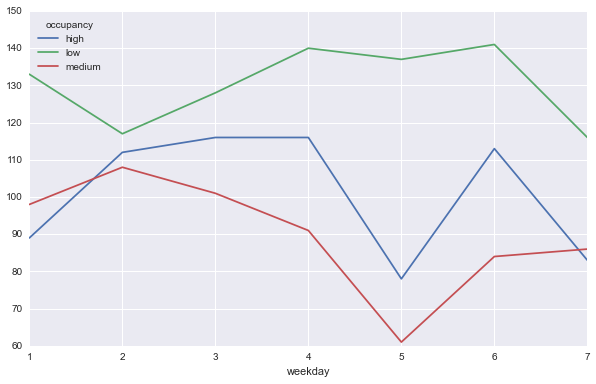

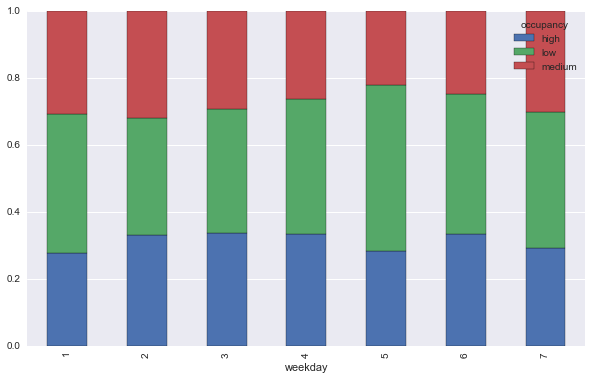

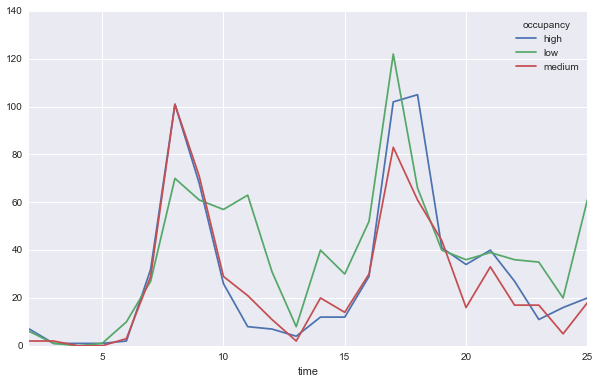

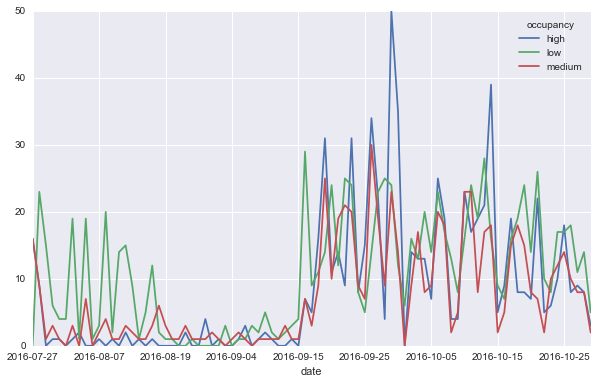

In [169]:
context=pd.crosstab(train_dataset.weekday,train_dataset.occupancy,rownames=['weekday'],colnames=['occupancy'])
context.plot(kind='line')

context.div(context.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

context2=pd.crosstab(train_dataset.time,train_dataset.occupancy,rownames=['time'],colnames=['occupancy'])
context2.plot(kind='line')


context2=pd.crosstab(train_dataset.date,train_dataset.occupancy,rownames=['date'],colnames=['occupancy'])
context2.plot(kind='line')

# Ver1:基于已有的特征进行预测

In [196]:
#生成哑变量

def generate_dummies(data1,data2,columns):
    all_data = data1.loc[:, columns].append(
            data2.loc[:, columns])
    category_dummies = pd.get_dummies(
        all_data[columns[0]], prefix=columns[0])
    return category_dummies[:data1.shape[0]], category_dummies[data1.shape[0]:]

train_from_dummies,test_from_dummies=generate_dummies(train_dataset,test_dataset,['from'])
train_to_dummies,test_to_dummies=generate_dummies(train_dataset,test_dataset,['to'])
train_vehicle_dummies,test_vehicle_dummies=generate_dummies(train_dataset,test_dataset,['vehicle'])

train_fit_dataset=train_dataset.loc[:,fit_columns+label_column].join(train_from_dummies).join(train_to_dummies).join(train_vehicle_dummies)
test_fit_dataset=test_dataset.loc[:,fit_columns].join(test_from_dummies).join(test_to_dummies).join(test_vehicle_dummies)

del test_fit_dataset['date']

In [172]:
#预留验证集 2016-10-23 ~ 2016-10-29
train_train=train_fit_dataset[train_fit_dataset.date<"2016-10-23"]
train_test=train_fit_dataset[train_fit_dataset.date>="2016-10-23"]

del train_train['date']
del train_test['date']

train_train_data=train_train.drop('occupancy',axis=1)
train_train_label=train_train.occupancy.tolist()
train_test_data=train_test.drop('occupancy',axis=1)
train_test_label=train_test.occupancy.tolist()

In [183]:
clf= xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=3)
clf.fit(train_train_data,train_train_label)

xgboost.sklearn.XGBClassifier

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [188]:
test_pre=clf.predict(train_test_data)
print metrics.classification_report(train_test_label, test_pre)

             precision    recall  f1-score   support

       high       0.33      0.34      0.33        62
        low       0.50      0.60      0.55        90
     medium       0.36      0.25      0.30        64

avg / total       0.41      0.42      0.41       216



In [203]:
result01=clf.predict(test_fit_dataset)
with open("result_170216.csv","w") as f:
    f.write("id,occupancy\n")
    for index,occ in enumerate(result01):
        f.write("%s,%s\n"%(index,label_map.get(occ)))

# 结果为：0.44539   目前排第二
---